In [37]:
severity_map = {
    "normal": 0,
    "IR007": 1,
    "IR014": 2,
    "IR021": 3,
    "IR028": 4
}

In [38]:
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [39]:
def load_de_signal(filepath):
    mat = sio.loadmat(filepath)
    key = [k for k in mat.keys() if 'DE_time' in k][0]
    signal = mat[key].flatten()
    return signal


In [40]:
def extract_features(signal):
    rms = np.sqrt(np.mean(signal**2))
    kurt = kurtosis(signal, fisher=False)  # normal ≈ 3
    
    return rms, kurt


In [43]:
normal_files = [
    "../data/raw/normal/normal_0.mat",
    "../data/raw/normal/normal_1.mat",
    "../data/raw/normal/normal_2.mat",
    "../data/raw/normal/normal_3.mat"
]

fault_groups = {
    "IR007": [
        "../data/raw/IR007/IR007_0.mat",
        "../data/raw/IR007/IR007_1.mat",
        "../data/raw/IR007/IR007_2.mat",
        "../data/raw/IR007/IR007_3.mat"
    ],
    "IR014": [
        "../data/raw/IR014/IR014_0.mat",
        "../data/raw/IR014/IR014_1.mat",
        "../data/raw/IR014/IR014_2.mat",
        "../data/raw/IR014/IR014_3.mat"
    ],
    "IR021": [
        "../data/raw/IR021/IR021_0.mat",
        "../data/raw/IR021/IR021_1.mat",
        "../data/raw/IR021/IR021_2.mat",
        "../data/raw/IR021/IR021_3.mat"
    ],
    "IR028": [
        "../data/raw/IR028/IR028_0.mat",
        "../data/raw/IR028/IR028_1.mat",
        "../data/raw/IR028/IR028_2.mat",
        "../data/raw/IR028/IR028_3.mat"
    ]
}


In [44]:
rows = []

# Normal bearings
for file in normal_files:
    signal = load_de_signal(file)
    rms, kurt = extract_features(signal)
    rows.append({
        "RMS": rms,
        "Kurtosis": kurt,
        "Label": "Normal",
        "Severity": 0,
        "File": file
    })


# Faulty bearings
for fault_type, files in fault_groups.items():
    for file in files:
        signal = load_de_signal(file)
        rms, kurt = extract_features(signal)
        rows.append({
            "RMS": rms,
            "Kurtosis": kurt,
            "Label": fault_type,
            "Severity": severity_map[fault_type],
            "File": file
        })


df = pd.DataFrame(rows)
df


,RMS,Kurtosis,Label,Severity,File
0,0.073764,2.764243,Normal,0,../data/raw/normal/normal_0.mat
1,0.066352,2.930617,Normal,0,../data/raw/normal/normal_1.mat
2,0.066352,2.930617,Normal,0,../data/raw/normal/normal_2.mat
3,0.065884,2.957169,Normal,0,../data/raw/normal/normal_3.mat
4,0.291526,5.395864,IR007,1,../data/raw/IR007/IR007_0.mat
5,0.292892,5.542255,IR007,1,../data/raw/IR007/IR007_1.mat
6,0.299510,5.563783,IR007,1,../data/raw/IR007/IR007_2.mat
7,0.313607,5.291053,IR007,1,../data/raw/IR007/IR007_3.mat
8,0.197830,21.957383,IR014,2,../data/raw/IR014/IR014_0.mat
9,0.165514,22.084265,IR014,2,../data/raw/IR014/IR014_1.mat


In [45]:
df["RMS_norm"] = (df["RMS"] - df["RMS"].min()) / (df["RMS"].max() - df["RMS"].min())
df["Kurtosis_norm"] = (df["Kurtosis"] - df["Kurtosis"].min()) / (df["Kurtosis"].max() - df["Kurtosis"].min())

df[["RMS_norm", "Kurtosis_norm"]]


,RMS_norm,Kurtosis_norm
0,0.010162,0.000000
1,0.000604,0.008612
2,0.000604,0.008612
3,0.000000,0.009986
4,0.290979,0.136212
5,0.292741,0.143789
6,0.301275,0.144904
7,0.319453,0.130787
8,0.170153,0.993433
9,0.128479,1.000000


In [46]:
df["Health"] = 100 * (
    1
    - 0.6 * df["RMS_norm"]
    - 0.3 * df["Kurtosis_norm"]
    - 0.1 * (df["Severity"] / df["Severity"].max())
)

df["Health"] = df["Health"].clip(0, 100)


<Axes: xlabel='RMS', ylabel='Kurtosis'>

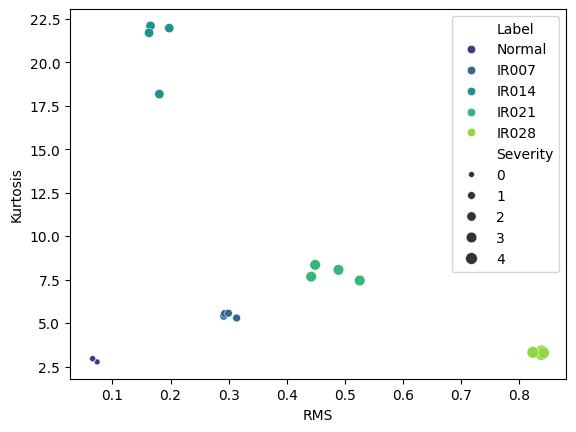

In [50]:
sns.scatterplot(
    data=df,
    x="RMS",
    y="Kurtosis",
    hue="Label",
    size="Severity",
    palette="viridis"
)



<Axes: xlabel='Label', ylabel='Health'>

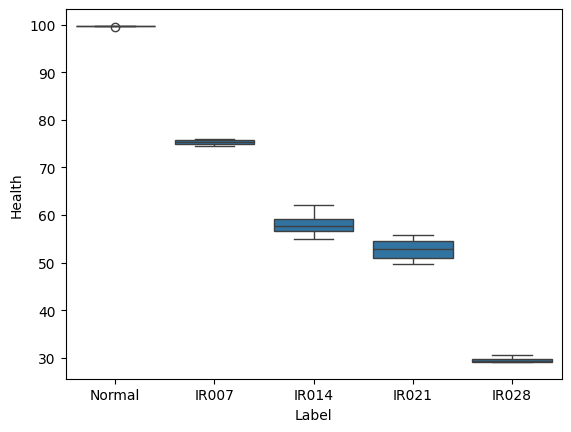

In [51]:
sns.boxplot(
    data=df,
    x="Label",
    y="Health",
    order=["Normal", "IR007", "IR014", "IR021", "IR028"]
)


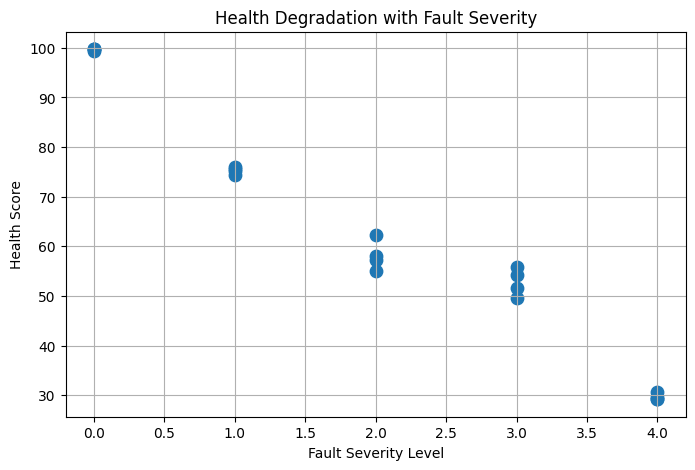

In [52]:
plt.figure(figsize=(8,5))
plt.scatter(df["Severity"], df["Health"], s=80)
plt.xlabel("Fault Severity Level")
plt.ylabel("Health Score")
plt.title("Health Degradation with Fault Severity")
plt.grid(True)
plt.show()

In [53]:
df.to_csv("../data/health_features_new.csv", index=False)
print("health_features.csv saved")


health_features.csv saved
